# CPU power scale

Loads precalculated relative performance between all the CPU modes/configurations.

Optimize placement of different CPUs on the "power scale" that goes between 0 and 1, by making multidimensional optimization trying to minimize errors in relative ratios for all the combinations of CPU pairs.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from scipy.optimize import minimize

### Load data

In [2]:
rel = pd.read_csv('c2c.csv')
rel = rel.set_index(rel.columns[0])

# to drop one CPU
#rel.drop(rel.index[[22]],inplace=True)
#rel.drop(rel.columns[22], axis=1,inplace=True)

cpus = rel.index.tolist()

toRemove=[]
for i,c in enumerate(cpus): 
    if c.endswith('HT') or c.endswith('VM'): toRemove.append(i)
#print(toRemove)

rel.head()
rel.drop(rel.index[toRemove],inplace=True)
rel.drop(rel.columns[toRemove], axis=1,inplace=True)

cpus = rel.index.tolist()

n=100
n=rel.shape[0]
# reduce size for debugging
rel=rel[:n]
rel=rel[rel.columns[0:n]]
rel.head()

clean = rel.reset_index(drop=True)
clean.columns=range(n)
clean = clean.replace(-1.0,np.nan)
pd.set_option('display.max_rows', n)
pd.set_option('display.max_columns', n)
print(clean)

     0         1         2         3         4         5         6         7   \
0   0.0  0.791919  0.901411  0.856731  1.340410  0.937691  0.980229  1.093855   
1   0.0  0.000000  1.150924  1.097418  1.381244  1.079221  1.033564  1.292004   
2   0.0  0.000000  0.000000  0.997527  1.287391  0.984343  0.960558  1.166988   
3   0.0  0.000000  0.000000  0.000000  1.316840  1.011665  1.040486  1.327597   
4   0.0  0.000000  0.000000  0.000000  0.000000  0.774414  0.770191  0.875069   
5   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.982417  1.266783   
6   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  1.112064   
7   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
10  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
11  0.0  0.000000  0.000000 

In [8]:
# for testing purposes
def test_simulated(): 
    x=[0.3, 0.4, 0.5, 0.6, 0.7]
    for i in range(5):
        for j in range(5):
            if i<=j: continue
            clean.set_value(j,i,x[i]/x[j])
    print(clean)

# prints all the values for one CPU
def print_cpu(i, df):
    print("index:",i, "CPU:", cpus[i])
    print(i,n)
    print("values:")
    print(df.iloc[0:i,i])
    print(df.iloc[i,i+1:n])
    
    
def plot_it(x,y=None):   
#     print ("original:",x)
    scaling_factor=len(x)*0.5 # mean of all values will be 0.5
    tot=sum(x)/scaling_factor
    xs = [i / tot for i in x]
    
    print ("scaled:")
    for i,w in enumerate(xs):
        print (w, cpus[i])
        
    width = 0.4
    if y:
#         print ("original:",y)
        scaling_factor=len(y)*0.5 # mean of all values will be 0.5
        tot=sum(y)/scaling_factor
        ys = [i / tot for i in y]
        print ("scaled:",ys)
    
    fig, ax = plt.subplots(figsize=(10, 15))
    fig.subplots_adjust(left=0.5, right=0.88)
    
    ax.barh(range(len(xs)), xs,  align='center', color='green')
    
    if y:
        ax.barh(range(len(ys)), ys, width, align='center', color='blue')
        
    ax.set_yticks(np.arange(len(xs)))
    ax.set_yticklabels(cpus)
    #ax.invert_yaxis()  # labels read top-to-bottom
    ax.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
    ax.set_xlabel('CPU Performance - higher values are better')
    ax.set_title('CPU power ranking')
    plt.savefig('CPU_power_ranking.png')
    plt.show()
#orig=[0.3,0.4,0.5,0.6,0.7]
#pred=[0.15210618071119994, 0.22699490354685253, 0.27314243774133101, 0.35586317159060538, 0.40030444830177297]
#plot_it(orig, pred)

### function to be optimized

In [4]:
def loss(x, verbose=False):
    # create the triangular dataframe from the input vector (guesses)
    guess = pd.DataFrame(0.0, index=np.arange(len(x)), columns=np.arange(len(x)))
    for i,c in enumerate(x):
        for j,r in enumerate(x):
            if i<=j: continue
            if np.isnan(c) or np.isnan(r):continue
            guess.set_value(j,i,c/r)
   # print(guess.head())
    
    err = (clean - guess)**2
    
    if verbose:
        print(err)
    
    #these values seem to be outlayers
    # print(err>1.0)
    err[err > 1.0] = 0
    
    err=err.replace(np.nan,0)
    return err.values.sum()

#print(loss([0.3,0.4,0.5,0.6,0.5])) 

### Optimize

minimal point: [ 0.44395168  0.36608283  0.415922    0.41611454  0.52906885  0.42255228
  0.39565211  0.48567061  0.48947064  0.52651864  0.55056895  0.56893422
  0.5586382   0.43122021  0.51727626  0.54534202  0.53223078  0.56905621
  0.4896594   0.52332582  0.44406283  0.62047754  0.70100139  0.59361459
  0.87341028  0.84022815  0.58822761  0.72669667  0.58892837  0.90985524
  0.64749861  0.61391709  0.87647856  0.70874876  0.58289319  0.66749183
  0.81694871  0.86582887  0.85352123  1.03762875  0.91195107  0.52787834
  0.45739448  0.40384848  0.44792944]
value at minimal point: 8.747244469881089
scaled:
0.368816177603 AMD Opteron(tm) Processor 6134
0.30412604695 AMD Opteron(tm) Processor 6168
0.345530315972 AMD Opteron(tm) Processor 6174
0.345690264028 Dual-Core AMD Opteron(tm) Processor 2216
0.439527908177 Dual-Core AMD Opteron(tm) Processor 2220
0.351038467867 Intel(R) Xeon(R) CPU           E5345  @ 2.33GHz
0.328690948711 Intel(R) Xeon(R) CPU           E5405  @ 2.00GHz
0.403474491

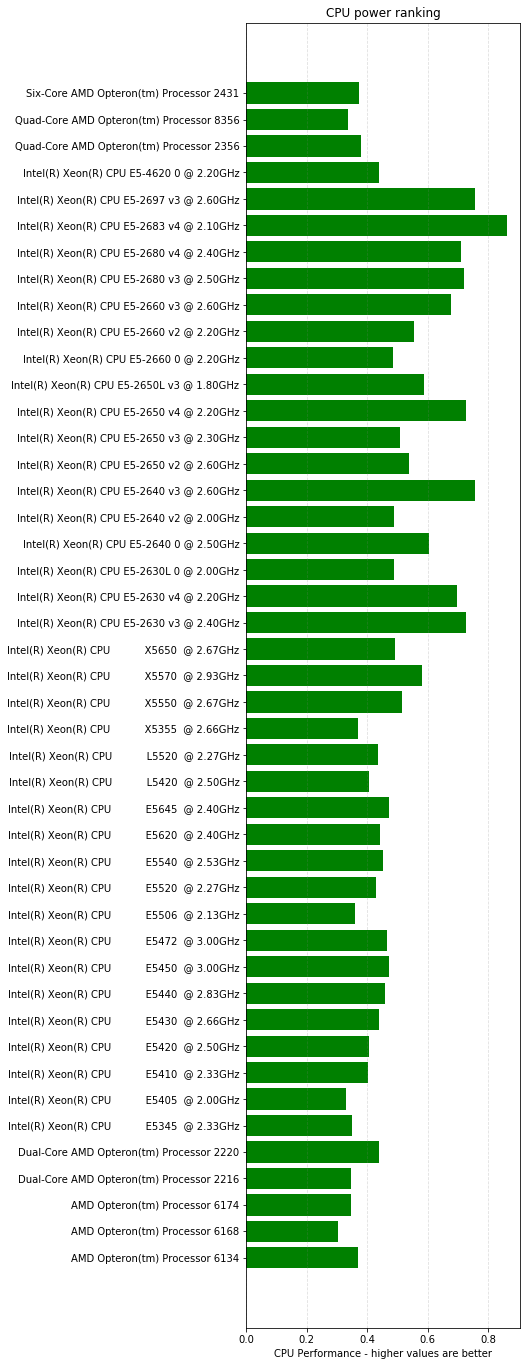

In [5]:
res = minimize(loss,[0.5]*len(clean))
print('minimal point:',res.x)
print('value at minimal point:',res.fun)
#print('values in minimization steps:',res.func_vals)




scaled:
0.368816177603 AMD Opteron(tm) Processor 6134
0.30412604695 AMD Opteron(tm) Processor 6168
0.345530315972 AMD Opteron(tm) Processor 6174
0.345690264028 Dual-Core AMD Opteron(tm) Processor 2216
0.439527908177 Dual-Core AMD Opteron(tm) Processor 2220
0.351038467867 Intel(R) Xeon(R) CPU           E5345  @ 2.33GHz
0.328690948711 Intel(R) Xeon(R) CPU           E5405  @ 2.00GHz
0.403474491084 Intel(R) Xeon(R) CPU           E5410  @ 2.33GHz
0.406631400717 Intel(R) Xeon(R) CPU           E5420  @ 2.50GHz
0.437409298375 Intel(R) Xeon(R) CPU           E5430  @ 2.66GHz
0.457389271554 Intel(R) Xeon(R) CPU           E5440  @ 2.83GHz
0.472646361217 Intel(R) Xeon(R) CPU           E5450  @ 3.00GHz
0.464092863036 Intel(R) Xeon(R) CPU           E5472  @ 3.00GHz
0.358239418356 Intel(R) Xeon(R) CPU           E5506  @ 2.13GHz
0.429731122326 Intel(R) Xeon(R) CPU           E5520  @ 2.27GHz
0.45304696563 Intel(R) Xeon(R) CPU           E5540  @ 2.53GHz
0.442154705688 Intel(R) Xeon(R) CPU           E5620

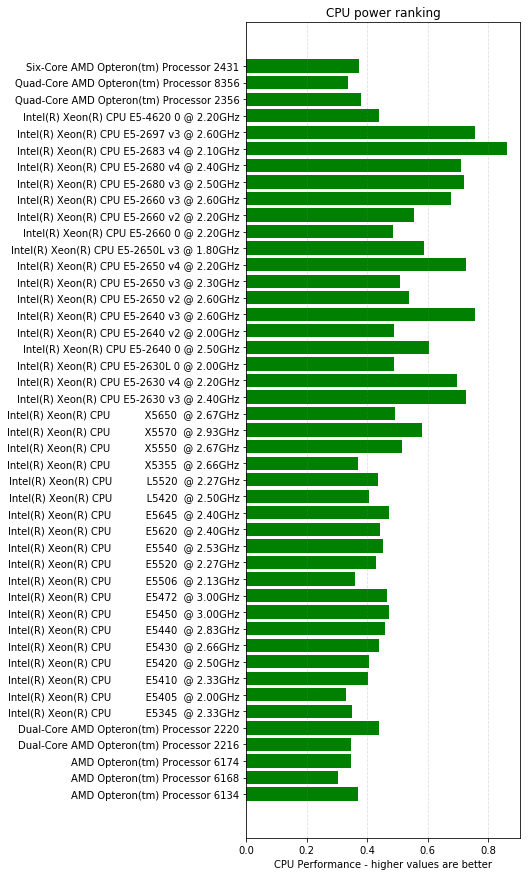

In [9]:
plot_it(res.x)

In [6]:
# find which CPU contributes most to error...
loss(res.x,True)

     0         1         2         3         4         5         6   \
0   0.0  0.001068  0.001257  0.006491  0.022107  0.000199  0.007925   
1   0.0  0.000000  0.000219  0.001541  0.004092  0.005630  0.002229   
2   0.0  0.000000  0.000000  0.000009  0.000236  0.000998  0.000086   
3   0.0  0.000000  0.000000  0.000000  0.002060  0.000014  0.008039   
4   0.0  0.000000  0.000000  0.000000  0.000000  0.000588  0.000500   
5   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.002123   
6   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
10  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
11  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
12  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
13  0.

8.7472444698810889

In [7]:
print_cpu(3,clean)
#print_cpu(27,clean)

index: 3 CPU: Dual-Core AMD Opteron(tm) Processor 2216
3 45
values:
0    0.856731
1    1.097418
2    0.997527
Name: 3, dtype: float64
4     1.316840
5     1.011665
6     1.040486
7     1.327597
8     1.213322
9     1.219690
10    1.380559
11    1.348055
12    1.445901
13    1.020047
14    1.212489
15    1.284145
16    0.986886
17    1.511482
18    1.328756
19    1.258946
20    1.113475
21    1.544558
22    1.792580
23    1.344967
24    1.796567
25    1.827009
26    1.516389
27    2.015451
28    1.350455
29    2.384516
30    1.293546
31    1.552436
32    1.855091
33    1.555417
34    1.316125
35    1.730864
36    1.878626
37    2.185552
38    1.978894
39    1.353450
40    2.391597
41    1.219892
42    1.138405
43    0.951472
44    1.095400
Name: 3, dtype: float64
